## BMI Calculator Workflow

In [8]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# Define State
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str

# Define Node
def calculateBMI(state: BMIState) -> BMIState:
    weight = state['weight_kg']
    height = state['height_m']
    bmi = weight/(height**2)
    state['bmi'] = round(bmi, 2)
    return state

def labelBMI(state: BMIState) -> BMIState:
    bmi = state['bmi']

    if bmi < 18.5:
        state['category'] = "Underweight"
    elif 18.5 <= bmi < 25:
        state['category'] = "Normal"
    elif 25 <= bmi < 30:
        state['category'] = "Overweight"
    else:
        state['category'] = "Obese"

    return state

In [27]:
# Define Graph
graph = StateGraph(BMIState)

# Add Nodes to Graph
graph.add_node("Calculate_BMI", calculateBMI)
graph.add_node("Label_BMI", labelBMI)

# Add Edges to Graph
graph.add_edge(START, "Calculate_BMI")
graph.add_edge("Calculate_BMI", "Label_BMI")
graph.add_edge("Label_BMI", END)

# Compile the Graph
workflow = graph.compile()

In [22]:
# Execute the Graph
initial_state = {
    'weight_kg':80,
    'height_m':1.7,
}

final_state = workflow.invoke(initial_state)
final_state

{'weight_kg': 80, 'height_m': 1.7, 'bmi': 27.68, 'category': 'Overweight'}

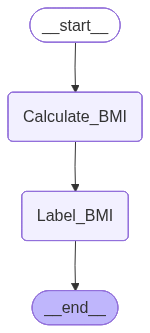

In [10]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

## LLM Workflow

In [35]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from dotenv import load_dotenv
load_dotenv()

llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    temperature=0.7,
    max_new_tokens=256,
)

model = ChatHuggingFace(llm=llm)

In [36]:
# Create a State
class LLMState(TypedDict):
    question: str
    answer: str

# Creating Nodes
def llmQuestion(state: LLMState) -> LLMState:
    # Extracting Question 
    question = state['question']

    # Prompt
    prompt = PromptTemplate(
        template="""Answer the following Question in around 29 words,
        Question:
        {question}
        """,
        input_variables=['question']
    )

    # Ask question to LLM
    chain = prompt | model | StrOutputParser()
    answer = chain.invoke({'question':question})

    # Update answer in state
    state['answer'] = answer

    return state

In [37]:
# Create Graph 
llmGraph = StateGraph(LLMState)

# Add Nodes
llmGraph.add_node("llmQuestion", llmQuestion)

# Create Edges
llmGraph.add_edge(START, "llmQuestion")
llmGraph.add_edge("llmQuestion", END)

# Compile the Graph
llmWorkflow = llmGraph.compile()

In [38]:
# Execute Graph
initial_state = {'question':"What is huggingface?"}
final_state = llmWorkflow.invoke(initial_state)
final_state['answer']

' Hugging Face is a technology company and community dedicated to advancing Natural Language Processing (NLP) through open source libraries like Transformers and datasets like the Hugging Face Dataset Hub. These resources make it easier for developers to build and deploy NLP applications.'

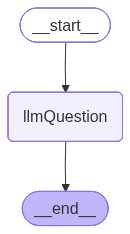

In [39]:
from IPython.display import Image
Image(llmWorkflow.get_graph().draw_mermaid_png())

## LLM Prompt Chain Workflow

In [40]:
# Create State
class BlogState(TypedDict):
    title: str
    outline: str
    content: str

# Create Node
def createOutline(state: BlogState) -> BlogState:
    prompt = PromptTemplate(
        template="""Create a detailed blog Outline for the topic: {title}""",
        input_variables=['title']
    )

    chain = prompt | model | StrOutputParser()

    state['outline'] = chain.invoke({'title': state['title']})

    return state

def createBlog(state: BlogState) -> BlogState:
    prompt = PromptTemplate(
        template="""Create a blog for the provided outline of a particular topic.
        Topic:
        {title}

        Provided outline on which have to create blog:
        {outline}
        """,
        input_variables=['title', 'outline']
    )

    chain = prompt | model | StrOutputParser()

    state['content'] = chain.invoke({
        'title': state['title'],
        'outline': state['outline']
    })

    return state

In [41]:
# Create Graph
blogGraph = StateGraph(BlogState)

# Add Nodes
blogGraph.add_node("createOutline", createOutline)
blogGraph.add_node("createBlog", createBlog)

# Add Edges
blogGraph.add_edge(START, "createOutline")
blogGraph.add_edge("createOutline", "createBlog")
blogGraph.add_edge("createBlog", END)

# Compile the Graph
blogWorkflow = blogGraph.compile()

In [43]:
# Execute Workflow
initial_state = {'title': "Acient Indian History"}

final_state = blogWorkflow.invoke(initial_state)
final_state

{'title': 'Acient Indian History',
 'outline': " Title: Unraveling the Mysteries of Ancient India: A Comprehensive Overview of India's Rich and Diverse History\n\nI. Introduction\n* Brief explanation of what Ancient India refers to (roughly 2500 BCE to 500 CE)\n* Importance of studying Ancient India in the context of world history\n\nII. Ancient Indian Civilizations\n* Indus Valley Civilization (Harappan Civilization)\n\t+ Location and Geography\n\t+ History and Timeline\n\t+ Architecture and Urban Planning\n\t+ Economy and Trade\n\t+ Culture and Society\n* Vedic Civilization\n\t+ Origins and Migration of the Indo-Aryans\n\t+ Social Structure and Caste System\n\t+ Religion and Philosophy\n\t+ Literature and Epics\n\nIII. Ancient Indian Art and Architecture\n* Overview of various artistic traditions in Ancient India\n* Influences and developments in architecture, sculpture, painting, and crafts\n* Significant architectural achievements, such as the Rock-cut temples and the Mahabodhi Tem

In [44]:
for key, value in final_state.items():
    print(f"{key} : {value}")

title : Acient Indian History
outline :  Title: Unraveling the Mysteries of Ancient India: A Comprehensive Overview of India's Rich and Diverse History

I. Introduction
* Brief explanation of what Ancient India refers to (roughly 2500 BCE to 500 CE)
* Importance of studying Ancient India in the context of world history

II. Ancient Indian Civilizations
* Indus Valley Civilization (Harappan Civilization)
	+ Location and Geography
	+ History and Timeline
	+ Architecture and Urban Planning
	+ Economy and Trade
	+ Culture and Society
* Vedic Civilization
	+ Origins and Migration of the Indo-Aryans
	+ Social Structure and Caste System
	+ Religion and Philosophy
	+ Literature and Epics

III. Ancient Indian Art and Architecture
* Overview of various artistic traditions in Ancient India
* Influences and developments in architecture, sculpture, painting, and crafts
* Significant architectural achievements, such as the Rock-cut temples and the Mahabodhi Temple

IV.
content :  Ancient India: A Ti